In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (14,8)
pd.options.display.mpl_style = 'default'
#pd.set_option('display.multi_sparse', True)

from collections import OrderedDict #sorting participant df dict before pd.concat()

from pprint import pprint
from pprint import pformat

import psutil
mem_free = lambda: psutil.phymem_usage().free / 1000000
mem_total = lambda: psutil.phymem_usage().total / 1000000


sms_tasknames = ['T1_SMS_5',       'T1_SMS_8',
                 'Ticks_ISO_T2_5', 'Ticks_ISO_T2_8',
                 'Ticks_Linear_5', 'Ticks_Linear_8',
                 'Ticks_Phase_5',  'Ticks_Phase_8',
                 'Jits_ISO_5',     'Jits_ISO_8',
                 'Jits_Linear_5',  'Jits_Linear_8',
                 'Jits_Phase_5',   'Jits_Phase_8', ]

# Participants that are excluded from all performance analysis
non_english_fluent  = [
                       #'010', '014', 
                       '023', '031', 
                       '045', '050', '070', '106',]

left_handed = ['042', '088',]

excluded_all_tasks = non_english_fluent + left_handed # + ...
excluded_pids = {t: list(excluded_all_tasks) for t in sms_tasknames}

# Add task-specific exclusions
# (just for testing, get real values later)
#excluded_pids['T1_SMS_5'].append('101')

In [2]:
#Open full stored dataset

pickled_dbase = "c:/db_pickles/pickle - dbase - 2014-10-03b.pickle"
dbase = pd.read_pickle(pickled_dbase)

db_pids = sorted(dbase.index.get_level_values('pid').unique())

db_sms = {task: dbase.xs(task, level='task_name') 
          for task in sms_tasknames}

task_pids = {task: sorted(df.index.get_level_values('pid').unique())
             for task, df in db_sms.iteritems()}

no_data_pids = {task: sorted(set(db_pids).difference(set(pids)))
                for task, pids in task_pids.iteritems()}

In [3]:
param_all_tasks = lambda v: {task: v for task in sms_tasknames}

sms_params_entry = {
    #used in filtering step
    #'wait_beats_after_task_start':                 param_all_tasks(9),
    'wait_beats_after_subj_start':                 param_all_tasks(12),
    #used in selecting correct tap from each beat
    'max_length_of_obvious_bounce':                param_all_tasks(30),
    'max_length_of_plausible_bounce':              param_all_tasks(150),
    #'min_percentISI_deviation_counted_as_failure': param_all_tasks(40),
    #used in assigning outlier status / "outlier metric"
    #'stdev_calcs_exclude_n_from_left':             param_all_tasks(2),
    #'stdev_calcs_exclude_n_from_right':            param_all_tasks(2),
    #'filter_outliers_beyond_x_stdevs':             param_all_tasks(3),  
    'stimulus_timing': {
        'T1_SMS_5':       'iso',
        'Ticks_ISO_T2_5': 'iso',
        'Ticks_Linear_5': 'linear',
        'Ticks_Phase_5':  'phase',
        'Jits_ISO_5':     'iso',
        'Jits_Linear_5':  'linear',
        'Jits_Phase_5':   'phase',
        'T1_SMS_8':       'iso',
        'Ticks_ISO_T2_8': 'iso',
        'Ticks_Linear_8': 'linear',
        'Ticks_Phase_8':  'phase',
        'Jits_ISO_8':     'iso',
        'Jits_Linear_8':  'linear',
        'Jits_Phase_8':   'phase',
        },
    'stimulus_style': {
        'T1_SMS_5':       'tick',
        'Ticks_ISO_T2_5': 'tick',
        'Ticks_Linear_5': 'tick',
        'Ticks_Phase_5':  'tick',
        'Jits_ISO_5':     'jitter',
        'Jits_Linear_5':  'jitter',
        'Jits_Phase_5':   'jitter',
        'T1_SMS_8':       'tick',
        'Ticks_ISO_T2_8': 'tick',
        'Ticks_Linear_8': 'tick',
        'Ticks_Phase_8':  'tick',
        'Jits_ISO_8':     'jitter',
        'Jits_Linear_8':  'jitter',
        'Jits_Phase_8':   'jitter',
        },
    'ISI': {
        'T1_SMS_5':       500,
        'Ticks_ISO_T2_5': 500,
        'Ticks_Linear_5': '(varies)',
        'Ticks_Phase_5':  500,
        'Jits_ISO_5':     500,
        'Jits_Linear_5':  '(varies)',
        'Jits_Phase_5':   500,
        'T1_SMS_8':       800,
        'Ticks_ISO_T2_8': 800,
        'Ticks_Linear_8': '(varies)',
        'Ticks_Phase_8':  800,
        'Jits_ISO_8':     800,
        'Jits_Linear_8':  '(varies)',
        'Jits_Phase_8':   800,
        },
    }

#reshape to task>param so parameter lists can be selected by task
sms_params = {task: {param_type: taskparams[task] 
                     for (param_type, taskparams) 
                     in sms_params_entry.items()}
              for task in sms_tasknames}
##or, equivalent but less fun:
#sms_params = {t: {} for t in sms_tasknames}
#for (param_name, taskparams) in sms_params_entry.items():
#    for task, value in taskparams.items():
#        sms_params[task][param_name] = value

LOOP_DELAY = 2.4 # ms, roundtrip arduino-module-arduino travel time


In [4]:
print('NO DATA:\n{0}\n\nEXCLUDED:\n{1}'
      .format(pformat(no_data_pids), 
              pformat(excluded_pids, width=100)))

NO DATA:
{'Jits_ISO_5': ['013', '031'],
 'Jits_ISO_8': ['013', '031'],
 'Jits_Linear_5': ['012', '018', '031'],
 'Jits_Linear_8': ['012', '013', '031'],
 'Jits_Phase_5': ['013'],
 'Jits_Phase_8': ['013', '031'],
 'T1_SMS_5': ['013', '031'],
 'T1_SMS_8': ['013', '031'],
 'Ticks_ISO_T2_5': ['013', '031'],
 'Ticks_ISO_T2_8': ['013', '031'],
 'Ticks_Linear_5': ['013', '031'],
 'Ticks_Linear_8': ['011', '013', '031'],
 'Ticks_Phase_5': ['013', '031'],
 'Ticks_Phase_8': ['013', '031']}

EXCLUDED:
{'Jits_ISO_5': ['010', '014', '023', '031', '045', '050', '070', '106', '042', '088'],
 'Jits_ISO_8': ['010', '014', '023', '031', '045', '050', '070', '106', '042', '088'],
 'Jits_Linear_5': ['010', '014', '023', '031', '045', '050', '070', '106', '042', '088'],
 'Jits_Linear_8': ['010', '014', '023', '031', '045', '050', '070', '106', '042', '088'],
 'Jits_Phase_5': ['010', '014', '023', '031', '045', '050', '070', '106', '042', '088'],
 'Jits_Phase_8': ['010', '014', '023', '031', '045', '050', '

In [7]:
def taps_by_beats(participant_task_data, task_params):
    
    pdata = participant_task_data
    if len(pdata) < 1:
        raise ValueError('zero-length data')

    sstyle =  task_params['stimulus_style']
    stiming = task_params['stimulus_timing']
    ISI =     task_params['ISI']
    
    target_source = {'tick': 'loopback', 'jitter': 'target'}
    btarget_stamps = pdata.xs(target_source[sstyle], 
                                 level='stamp_type')

    if sstyle == 'jitter':
        # For these tasks, we need to find the middle of the beat differently.
        # for other tasks, the Arduino program used the "target" timestamp 
        # designation to indicate when the stimuli were sent out toward the module.
        # For jitter tasks, however, the 'target' stamp was placed halfway between 
        # midpoints of distributions of jittered stimuli.         
        # The 'target' stamp was made when serial output was sent to the PC, and
        # because sending serial output creates a lag in the arduino's data recording,
        # the output needed to be sent at a time that we didn't need to be keeping close
        # track of incoming performance data, i.e., halfway between the stimulus 
        # distribution midpoints.        
        # Memory constraints prevented the program from just holding onto all of the
        # data until a serial dump at the end of the task, which is what was done
        # for the other tasks, where there were fewer stimulus events to keep track of.
        
        # Subtract 250 or 400 ms from each 'target' stamp to estimate the midpoint of 
        # the generating distribution for the randomly-jittered stimuli. 
        if stiming == 'iso':
            adjust = (-1 * ISI / 2) 
        # here, "adjust" is a series. find the middle of the beat based on the current
        # beat duration (and still halfway between the "target" designation in output)
        elif stiming == 'phase':
            #evaluate this!
            adjust = (-1 * ISI / 2) 
        elif stiming == 'linear':
            intervals = btarget_stamps.task_ms - btarget_stamps.task_ms.shift(1)
            adjust = (-1 * intervals / 2)
        else:
            raise ValueError
            
        #LOOP_DELAY defined above (2.4):
        # 2.4 ms == average midi travel time. 'target' was stamped at arduino output
        # time, and stimuli/taps were stamped at arduino input time. Roundtrip from
        # arduino to module to arduino is about 2.4 ms on average.
        
        # tricky: we're using 'adjust' as a scalar for 'iso', 
        # and using it as a series for 'linear'!
        
        btarget_stamps.task_ms = (btarget_stamps.task_ms + 
                                  adjust + LOOP_DELAY)
        # Need to set up for 'phase' tasks above. When running phase task:
        #UnboundLocalError: local variable 'adjust' referenced before assignment
        btarget_stamps.micros = (btarget_stamps.micros + 
                                 (1000 * (adjust + LOOP_DELAY)))

        #Could also experiment with this: do participants tap closer to a consistent
        #center-of-distribution-as-calculated beat? Or do they tap closer to the
        #actual empirical timings that were produced for the stimuli? Or do they
        #just tap along with a particular instrument?
    
    
    # assign beat numbers for loopback stimuli measurements, 
    # and set a range of -1/2 interval to +1/2 interval to 
    # group the tap/stim events into beats.
        
    # add a new index (zero-indexed) for beats
    btarget_stamps.index = range(len(btarget_stamps))
    btargets = pd.DataFrame(btarget_stamps)
    btargets.index.name = 'beat'
    btargets['stamp'] = 'btarget'
    btargets.set_index('stamp', append=True, inplace=True)    
    assert btargets.index.names == ('beat', 'stamp')

    #first beat would get NaN values, so set the start of beat 0 to 0 ms
    btarget_stamps.loc[0, 'task_ms'] = 0
    #print(btargets)
    assert btargets.iloc[0].task_ms == 0        
    
    #calculate interval between btargets (already had this as 'int_raw',
    # but it might be useful to be able to recalculate this from particular
    # subsets of the stimulus later, e.g., center of jitter group?)
    btargets['beat_target'] = tstamp = btargets.task_ms    
    btargets['tinterval'] = tstamp - tstamp.shift(1)
    int_change = btargets.tinterval - btargets.shift(1).tinterval
    btargets['target_spiked'] = (abs(int_change) > 15)

    btargets['beat_start'] = tstamp.shift(1) + (btargets.tinterval / 2)
    btargets['beat_start'].iloc[0] = 0.0 # shift(1) left a leading NaN
    
    btargets['beat_end'] = btargets.shift(-1).beat_start    
    # shift(-1) left a trailing NaN. Estimate using the previous interval
    end = btargets.iloc[-1].beat_target + (btargets.iloc[-1].tinterval / 2)
    btargets['beat_end'].iloc[-1] = end  
    

    #pull out the taps series and then assign to the beats created above.    
    taps = pd.DataFrame(pdata.xs('tap_r', level='stamp_type'))
    taps['stamp'] = 'tap'
    taps.set_index('stamp', inplace=True)    
    
    beatset = btargets
    for beatnum, stampname in btargets.index.values: #e.g., 0 to 119 for SMS800 T2
        target_df = btargets.xs(beatnum, level='beat', drop_level=False)
        assert target_df.shape[0] == 1 
        assert target_df['task_ms'].count() == 1
        target = target_df.iloc[0]        
        taps_in_beat = taps[(taps.task_ms >= target.beat_start) &
                            (taps.task_ms <  target.beat_end)]        
        taps_in_beat['beat_start']  = target.beat_start
        taps_in_beat['beat_end']    = target.beat_end
        taps_in_beat['beat_target'] = target.task_ms        
        taps_in_beat['beat'] = beatnum        
        taps_in_beat = taps_in_beat.set_index('beat', append=True)
        taps_in_beat = taps_in_beat.swaplevel('beat', 'stamp')
        beatset = beatset.append(taps_in_beat)
    beatset = beatset.sort()

    beatgroups = beatset.groupby(level='beat')
    def deviations(beatgrp):
        targetdf = beatgrp.xs('btarget', level='stamp')
        assert len(targetdf.index) == 1
        target = targetdf.iloc[0]        
        beatgrp['dev'] = beatgrp.task_ms - target.task_ms
        beatgrp['dev_perc'] = 100 * beatgrp.dev / target.tinterval
        #the above formula will be incorrect for the first beat (the 
        #interval is half-length) but we're discarding initial beats anyway.
        return beatgrp
    beatgroups = beatgroups.apply(deviations)
    
    remdevs = beatgroups.xs('btarget', level='stamp')
    remdevs.dev = np.nan
    remdevs.dev_perc = np.nan    
    
    return beatgroups.sort()
    

In [8]:
phase_shift_beats = {800: 
                         {30: -20,
                          48: +20,
                          64: +40,
                          81: -40,
                          97: -80,
                          114: +80,
                          131: +160,
                          150: -160},
                     500: 
                         {64: +20,
                          81: -20,
                          97: -50,
                          114: +50,
                          131: +100,
                          150: -100} }


def add_phase_shift_info(participant_task_data, task_params):
    
    df = participant_task_data    
    ISI =     task_params['ISI']
    stiming = task_params['stimulus_timing']
    assert stiming == 'phase'

    shifts = phase_shift_beats[ISI]
    shift_beats = sorted(shifts.keys())
    beatnums = sorted(set(df.index.get_level_values('beat')))

    df['shifted_ms_before_target'] = np.nan
    df['last_shift_val'] = np.nan
    
    for b in beatnums:
        
        previous_beats = range(b)
        previous_shift_beats = [s for s in shift_beats if s in previous_beats]

        if b in shift_beats:

            df.loc[(b, 'target'), 'shifted_ms_before_target'] = 0
            df.loc[(b, 'target'), 'last_shift_val'] = shifts[b]

        elif not previous_shift_beats:

            df.loc[(b, 'target'), 'last_shift_val'] = np.nan
            df.loc[(b, 'target'), 'shifted_ms_before_target'] = np.inf

        else:

            last_shift_beat = max(previous_shift_beats)
            last_shift_beat_time = df.loc[(last_shift_beat, 'target')].task_ms

            last_shift_beat_amount = shifts[last_shift_beat]
            last_shift_ms_ago = df.loc[(b, 'target')].task_ms - last_shift_beat_time

            df.loc[(b, 'target'), 'last_shift_val'] = last_shift_beat_amount
            df.loc[(b, 'target'), 'shifted_ms_before_target'] = last_shift_ms_ago


        lsv = df.loc[(b, 'target'), 'last_shift_val']
        df.loc[(b, 'tap'), 'last_shift_val'] = lsv

        smbt = df.loc[(b, 'target'), 'shifted_ms_before_target']
        df.loc[(b, 'tap'), 'shifted_ms_before_target'] = smbt


    return df


In [10]:
def select_best_tap(beat, task_params):
    ''' Input: taps only (no stimuli), for a single beat
        Output: a single tap, counted as the proper attempt for this beat'''
    #Remember: always return a row (iloc[0]), not the whole 'beat' group.
    #Otherwise the combined output does weird things like duplicating the index.
    len_obviousbounce = task_params['max_length_of_obvious_bounce']
    len_plausiblebounce = task_params['max_length_of_plausible_bounce']
    #dev_failure = task_params['min_deviation_counted_as_failure']
    #devperc_failure = task_params['min_percentISI_deviation_counted_as_failure']
 
    #print(beat)
    
    targetdf = beat.xs('btarget', level='stamp')
    assert len(targetdf.index) == 1
    target = targetdf.iloc[0]
    target_int = target.tinterval
    target_ms = target.task_ms
    
    taps = beat.xs('tap', level='stamp')    
    tapcount = len(taps.index)

    taps['selection_case'] = np.nan
    taps['multiple_taskms'] = ""    
    
    if tapcount < 1:     
        return None
    
    # Case 1: Only one tap registered for this beat.
    if tapcount == 1:
        taps.selection_case = 1
        return taps.iloc[0]
    
    first = taps.iloc[0]
    second = taps.iloc[1]
    last = taps.iloc[-1]
    all_task_ms = taps.task_ms.tolist()
    
    assert first.task_ms < second.task_ms <= last.task_ms
    assert first.beat_target == second.beat_target == last.beat_target
    #target = first.beat_target
    # (changed to target_ms calculated above)
    
    
    # Case 2: Very quick bounces-- keep timing of first
    #         but set velocity to whichever is loudest.
    
    if (last.task_ms - first.task_ms <= len_obviousbounce):
        selection_case = 2
        selected = taps[taps.task_ms == first.task_ms]
        selected.velocity = taps.velocity.max()
        
    # Case 3: Slower bounces, but the taps aren't extremely far apart.
    #         Keep the first, but retain the velocity of that tap 
    #         (rather than getting the "peak" as in Case 2).
    
    elif (last.task_ms - first.task_ms <= len_plausiblebounce):   
        selection_case = 3
        selected = taps[taps.task_ms == first.task_ms]
        
    # Case 4: Not a bounce (they're too far apart to be a quick bounce,
    #         and it's not likely to be a slow bounce because Case 3
    #         wasn't satisfied), but there are two taps. Perhaps the
    #         participant is trying to realign. Keep the closest tap.
    #         (this shouldn't happen often, so check the output for
    #         the number of selection_case=4 entries.)
    
    else:
        selection_case = 4
        smallest_perc_dev = taps.dev_perc.apply(abs).min()
        selected = taps[abs(taps.dev_perc) == smallest_perc_dev]

    try:
        assert len(selected) == 1
    except AssertionError:
        print('selection case was %s' % selection_case)
        print('number of selected taps was %s' % len(selected))
        raise
        
    selectedt = selected.iloc[0]
    selectedt.selection_case = selection_case
    
    multiple_tap_info = ','.join([str(int(t)) for t in all_task_ms])
    selectedt.multiple_taskms = multiple_tap_info #includes the retained tap

    return selectedt
    
    
    # Case 5: above cases didn't apply.
    # Unusual (for SMS800, happened 11 times across
    # eight participants among the full sample). 
    # Here, we've established that we just keep the highest-velocity tap.
    #else:
    #    selected = taps[taps.velocity == taps.velocity.min()]
    #    if len(selected) > 1:
    #        selected = selected[selected.dev == selected.dev.min()]
    #    assert len(selected) == 1
    #    selected['selection_case'] = 5
    #    return selected.iloc[0]
    
    # Selection will fall through to case 5 if beats are set up incorrectly.
    # In bug testing I found that final intervals ended too late, so the
    # point where a participant does one final tap after the task has actually
    # ended was included in this interval. This situation didn't fit any of
    # cases 1-3 because the taps were so far apart. Then it didn't fit case 4
    # because the first tap (which was actually supposed to be in that beat)
    # was very close to the target, whereas the last tap (which was after the
    # task ended) was very far away from the target.

In [12]:
def print_task_info(taskname):
    print('\n' + ('='*70))
    print('* ' + taskname)
    print('* No data for IDs: {}'.format(', '.join(no_data_pids[taskname])))
    print('* IDs excluded: {}'.format(', '.join(excluded_pids[taskname])))
    print('-'*40)

#def progress_wave(i):
#    print("_.~*^`=~-."[int(i) % 10], end='')
#    return

In [13]:
def sms_task_processing(participant_data, task_params, print_beats=False):

    participant_data.drop(['int_raw', 'run_count', 'task_id'],
                           axis=1, inplace=True)

    beats = taps_by_beats(participant_data, task_params)
    
    if print_beats: 
        print(beats)
        
    beatgroups = beats.groupby(level='beat')
    selected = beatgroups.apply(lambda g: select_best_tap(g, task_params))

    # convenient way of identifying the blank 'tap' items in the series
    # that were inserted during select_best_tap() whenever the number of 
    # taps in a beat was zero.
    selected['is_failure'] = np.isnan(selected.micros)
        
    selected['ints'] = selected.task_ms - selected.task_ms.shift(1)

    targets = beats.xs('btarget', level='stamp')
    
    #Run filters later-- we
    #want to keep all of the data for now, except decisions that we
    #have to make immediately (mainly, which tap to keep in intervals
    #that contain multiple taps, as selected above by select_best_tap().)

    #filtered = filter_taps(...) #moved to part 4 notebook
    #filtered[filtered.is_outlier]
    
    combined = pd.concat([selected, targets], 
                         keys=['tap','target'], 
                         names=['stamp'])
    
    combined = combined.swaplevel('beat', 'stamp').sort()
    
    if task_params['stimulus_timing'] == 'phase':
        combined = add_phase_shift_info(combined, task_params)
    

    return combined

In [15]:
def process_sms_task_set(sms_params, testing_subset=False):
    
    import psutil
    
    task_frames = OrderedDict()
    task_pid_iteration = 0
    
    for taskname in sms_tasknames:
        
        #testing out phase tasks only
        #if 'Phase' not in taskname:
        #    continue
        ########
        
        task_data = db_sms[taskname]
        task_params = sms_params[taskname]
        pids_using = [p for p in task_pids[taskname] 
                      if p not in excluded_pids[taskname]]
        
        print_task_info(taskname)
        
        mem_free = psutil.virtual_memory()[1] / 1000000
        print("{} megs free memory".format(mem_free))
        
        pid_frames = OrderedDict()
        
        for pid in pids_using:
            
            task_pid_iteration += 1
            
            if testing_subset and (task_pid_iteration % testing_subset != 0):
                #for testing: skip all except every N task/participant combos
                continue
                
            print(pid + ',', end='')
            
            participant_data = task_data.xs(pid, level='pid')
            
            processed = sms_task_processing(participant_data, 
                                            task_params)     
            pid_frames[pid] = processed        
            
        task_finished = pd.concat(pid_frames,
                                  keys=pid_frames.keys(), 
                                  names=['pid'])
        
        task_frames[taskname] = task_finished

    return task_frames
    

tframes = process_sms_task_set(sms_params=sms_params,
                               testing_subset=40,
                               )

import cPickle as pickle
#output_file="c:/db_pickles/pickle - smsbeats - 2014-10-03b.pickle"
output_file="c:/db_pickles/pickle - smsbeats - 2014-10-12a SUBSET.pickle"
pickle.dump(tframes, open(output_file, "wb"))


* T1_SMS_5
* No data for IDs: 013, 031
* IDs excluded: 010, 014, 023, 031, 045, 050, 070, 106, 042, 088
----------------------------------------
3418 megs free memory
057,099,
* T1_SMS_8
* No data for IDs: 013, 031
* IDs excluded: 010, 014, 023, 031, 045, 050, 070, 106, 042, 088
----------------------------------------
3403 megs free memory
033,077,119,
* Ticks_ISO_T2_5
* No data for IDs: 013, 031
* IDs excluded: 010, 014, 023, 031, 045, 050, 070, 106, 042, 088
----------------------------------------
3408 megs free memory
055,097,
* Ticks_ISO_T2_8
* No data for IDs: 013, 031
* IDs excluded: 010, 014, 023, 031, 045, 050, 070, 106, 042, 088
----------------------------------------
3395 megs free memory
030,075,117,
* Ticks_Linear_5
* No data for IDs: 013, 031
* IDs excluded: 010, 014, 023, 031, 045, 050, 070, 106, 042, 088
----------------------------------------
3396 megs free memory
053,095,
* Ticks_Linear_8
* No data for IDs: 011, 013, 031
* IDs excluded: 010, 014, 023, 031, 045, 05

C:\Applications\_Data analysis\Anaconda\lib\site-packages\pandas\core\generic.py:1858: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  self[name] = value


In [16]:
#output_file="c:/db_pickles/task_frames_sms_20140918a_subset.pickle"
#pickle.dump(tframes, open(output_file, "wb"))

t = tframes.keys()[0]
print(t)
df = tframes[t]

dfsubset = df.drop(['pitch', 'channel', 'is_failure', 'selection_case', 'micros', 'velocity', 'i', 'multiple_taskms'], axis=1)

dfsubset[::10]


T1_SMS_5


beat_end  beat_start  beat_target     dev   dev_perc  \
pid beat stamp                                                          
011 0    tap          NaN         NaN          NaN     NaN        NaN   
    5    tap     2749.968    2249.638     2499.580  10.124   2.025270   
    10   tap     5250.118    4750.394     5000.260 -17.716  -3.545100   
    15   tap     7750.044    7249.908     7499.700 -11.688  -2.339547   
    20   tap    10250.200    9749.908    10000.296  -4.692  -0.936946   
    25   tap    12749.804   12250.000    12499.864 -38.144  -7.632952   
    30   tap    15250.610   14750.240    15000.712   0.900   0.179661   
    35   tap    17749.886   17250.188    17500.016 -13.640  -2.729878   
    40   tap    20250.028   19749.726    19999.556 -14.164  -2.834728   
    45   tap    22750.154   22249.968    22500.400  -9.204  -1.837625   
    50   tap    25249.724   24750.588    24999.892 -13.336  -2.674646   
    55   tap    27750.206   27249.982    27500.340   4.188   0.836402   
    60   tap    30249.932   29750.162    30000.028  23.208   4.644089   
    65   tap    32750.150   32249.926    32499.944   3.364   0.672752   
    70   tap    35250.014   34749.834    35000.112  -5.292  -1.057224   
    75   tap    37749.674   37250.032    37499.712  24.332   4.872637   
    80   tap    40250.296   39750.148    40000.500  -6.872  -1.372468   
    85   tap    42749.930   42250.200    42500.064  -2.360  -0.472257   
    90   tap    45249.952   44749.768    44999.560   7.420   1.485236   
    95   tap    47750.228   47250.418    47500.324   8.396   1.679832   
    100  tap    50249.814   49750.156    50000.136  -9.356  -1.871350   
    105  tap    52750.282   52250.136    52500.376 -29.800  -5.954284   
    110  tap    55249.858   54750.092    54999.996  28.544   5.710993   
    115  tap    57749.990   57249.802    57499.784  63.804  12.761719   
    120  tap    60250.056   59750.432    60000.228  13.284   2.658970   
    125  tap    62750.180   62249.960    62499.788  33.736   6.751845   
012 0    tap          NaN         NaN          NaN     NaN        NaN   
    5    tap     2750.556    2250.862     2500.764  39.068   7.816664   
    10   tap     5250.582    4750.474     5000.232   5.016   1.004172   
    15   tap     7750.782    7250.558     7500.912 -33.112  -6.613036   
...                   ...         ...          ...     ...        ...   
120 110  tap    55249.474   54749.292    54999.140 -10.808  -2.162915   
    115  tap    57749.534   57249.764    57499.612 -16.416  -3.285197   
    120  tap    60250.400   59750.144    60000.700  -1.336  -0.266607   
    125  tap    62749.702   62249.370    62499.776  -2.800  -0.559092   
121 0    tap          NaN         NaN          NaN     NaN        NaN   
    5    tap     2749.818    2249.600     2499.448  17.028   3.407672   
    10   tap     5249.968    4749.822     5000.156 -18.584  -3.711841   
    15   tap     7749.570    7249.802     7499.612  30.572   6.119050   
    20   tap    10250.096    9749.918    10000.248 -13.568  -2.710023   
    25   tap    12749.754   12250.020    12500.016 -26.292  -5.258484   
    30   tap    15249.836   14749.618    14999.392 -14.244  -2.851378   
    35   tap    17749.958   17250.156    17500.040  29.452   5.893134   
    40   tap    20249.552   19749.744    19999.704 -15.216  -3.043687   
    45   tap    22750.056   22249.776    22500.172 -37.584  -7.504912   
    50   tap    25249.692   24749.880    24999.692 -24.120  -4.827630   
    55   tap    27749.884   27249.776    27499.736 -29.580  -5.916947   
    60   tap    30249.964   29750.194    30000.004 -24.268  -4.857292   
    65   tap    32750.106   32249.864    32499.896 -42.092  -8.417323   
    70   tap    35249.960   34749.924    35000.076   9.032   1.805302   
    75   tap    37749.772   37249.890    37499.812 -40.500  -8.102528   
    80   tap    40249.858   39749.714    39999.636 -58.824 -11.768472   
    85   tap    42749.792   42250.170    42499.980 -24.888  -4.981386   
  

In [25]:
dfsubset.groupby(level=0).beat_target.count().min()

248

In [ ]:
import cPickle as pickle
with open("c:/db_pickles/pickle - smsbeats - 2014-10-03b.pickle") as f:
    task_frames = pickle.load(f)
    
task = sms_tasknames[0]
print(task)
task_frames[task]

In [113]:
pprint(list(enumerate(task_frames.keys())))

df = task_frames[task_frames.keys()[6]]

df[df.selection_case > 1]

[(0, 'T1_SMS_5'),
 (1, 'T1_SMS_8'),
 (2, 'Ticks_ISO_T2_5'),
 (3, 'Ticks_ISO_T2_8'),
 (4, 'Ticks_Linear_5'),
 (5, 'Ticks_Linear_8'),
 (6, 'Ticks_Phase_5'),
 (7, 'Ticks_Phase_8'),
 (8, 'Jits_ISO_5'),
 (9, 'Jits_ISO_8'),
 (10, 'Jits_Linear_5'),
 (11, 'Jits_Linear_8'),
 (12, 'Jits_Phase_5'),
 (13, 'Jits_Phase_8')]


beat_end  beat_start  beat_target  channel     dev  \
pid beat stamp                                                        
094 8    tap     4259.732    3759.942     4009.860        1 -22.452   
    17   tap     8769.866    8269.630     8519.508        1  -8.112   
    28   tap    14275.570   13770.170    14020.380        1 -60.768   
    49   tap    24779.726   24279.900    24529.784        1  42.664   
    67   tap    33799.908   33299.854    33550.000        1 -42.352   
    75   tap    37799.752   37300.034    37549.808        1   8.440   
    79   tap    39799.738   39299.886    39549.756        1 -75.872   
    80   tap    40289.684   39799.738    40049.720        1 -58.344   
    129  tap    64809.708   64310.216    64559.912        1 -20.848   

                 dev_perc    i  interval     ints is_failure     micros  \
pid beat stamp                                                            
094 8    tap    -4.491873   12       NaN  514.660      False  672423420   
    17   tap    -1.623192   31       NaN  487.772      False  676947408   
    28   tap   -12.143400   54       NaN  496.168      False  682395624   
    49   tap     8.536761   98       NaN  576.992      False  693008460   
    67   tap    -8.465456  134       NaN  511.516      False  701943660   
    75   tap     1.689527  152       NaN  552.828      False  705994260   
    79   tap   -15.182295  160       NaN  429.068      False  707909896   
    80   tap   -11.669640  163       NaN  517.492      False  708427388   
    129  tap    -4.174676  262       NaN  480.188      False  732975076   

                pitch  selection_case target_spiked    task_ms  velocity  
pid beat stamp                                                            
094 8    tap       48               3           NaN   3987.408        50  
    17   tap       48               3           NaN   8511.396        53  
    28   tap       48               3           NaN  13959.612        55  
    49   tap       48               3           NaN  24572.448        47  
    67   tap       48               3           NaN  33507.648        56  
    75   tap       48               3           NaN  37558.248        51  
    79   tap       48               3           NaN  39473.884        54  
    80   tap       48               3           NaN  39991.376        51  
    129  tap       48               3           NaN  64539.064        48

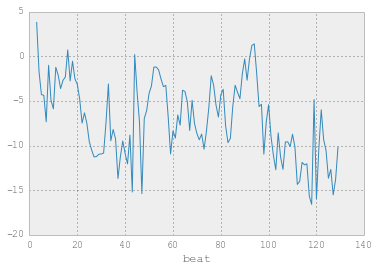

In [25]:
testvals = task_frames[task].dev_perc

inverted = 1 / testvals

testvals.xs('099').xs('tap', level='stamp').plot()

In [111]:
db_sms.keys()

['T1_SMS_5',
 'Jits_Phase_5',
 'Ticks_Phase_5',
 'Jits_Phase_8',
 'Ticks_Phase_8',
 'T1_SMS_8',
 'Jits_Linear_8',
 'Ticks_Linear_8',
 'Ticks_ISO_T2_5',
 'Jits_ISO_5',
 'Jits_ISO_8',
 'Ticks_Linear_5',
 'Jits_Linear_5',
 'Ticks_ISO_T2_8']

In [50]:
#For testing

taskname = 'Jits_Linear_8'
pid = '095'


task_data = db_sms[taskname]
task_params = sms_params[taskname]
participant_data = task_data.xs(pid, level='pid')

output = sms_task_processing(participant_data, 
                             sms_params[taskname])

#filtered = filter_taps(...) #moved to part 4 notebook
#filtered[filtered.is_outlier]

#plt.xlim(90, 100)
#plt.ylim(0.5,1.5)
#filtered.ints.plot(figsize=(12,6))
#plt.show()

                beat_end  beat_start  beat_target  channel    i  interval  \
beat stamp                                                                  
0    btarget     409.906       0.000        0.000      NaN    0       NaN   
1    btarget    1229.910     409.906      819.812      NaN    1   819.812   
2    btarget    2050.125    1229.910     1640.008      NaN    2   820.196   
     tap        2050.125    1229.910     1640.008        1    1       NaN   
3    btarget    2870.355    2050.125     2460.242      NaN    3   820.234   
     tap        2870.355    2050.125     2460.242        1    2       NaN   
4    btarget    3688.027    2870.355     3280.468      NaN    4   820.226   
     tap        3688.027    2870.355     3280.468        1    2       NaN   
5    btarget    4500.576    3688.027     4095.586      NaN    5   815.118   
     tap        4500.576    3688.027     4095.586        1    0       NaN   
6    btarget    5310.559    4500.576     4905.566      NaN    6   809.980   

In [51]:
output

,,beat_end,beat_start,beat_target,channel,dev,dev_perc,i,interval,ints,is_failure,is_outlier,micros,outlier_metric,pitch,target_spiked,task_ms,velocity
beat,stamp,,,,,,,,,,,,,,,,,
0,target,409.906,0.000,0.000,NaN,0.000,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000,NaN
1,target,1229.910,409.906,819.812,NaN,0.000,0.000000,1,819.812,NaN,NaN,NaN,1737800632,NaN,NaN,False,819.812,NaN
2,target,2050.125,1229.910,1640.008,NaN,0.000,0.000000,2,820.196,NaN,NaN,NaN,1738620828,NaN,NaN,False,1640.008,NaN
3,target,2870.355,2050.125,2460.242,NaN,0.000,0.000000,3,820.234,NaN,NaN,NaN,1739441062,NaN,NaN,False,2460.242,NaN
4,target,3688.027,2870.355,3280.468,NaN,0.000,0.000000,4,820.226,NaN,NaN,NaN,1740261288,NaN,NaN,False,3280.468,NaN
5,target,4500.576,3688.027,4095.586,NaN,0.000,0.000000,5,815.118,NaN,NaN,NaN,1741076406,NaN,NaN,False,4095.586,NaN
6,target,5310.559,4500.576,4905.566,NaN,0.000,0.000000,6,809.980,NaN,NaN,NaN,1741886386,NaN,NaN,False,4905.566,NaN
7,target,6120.554,5310.559,5715.552,NaN,0.000,0.000000,7,809.986,NaN,NaN,NaN,1742696372,NaN,NaN,False,5715.552,NaN
8,target,6930.545,6120.554,6525.556,NaN,0.000,0.000000,8,810.004,NaN,NaN,NaN,1743506376,NaN,NaN,False,6525.556,NaN


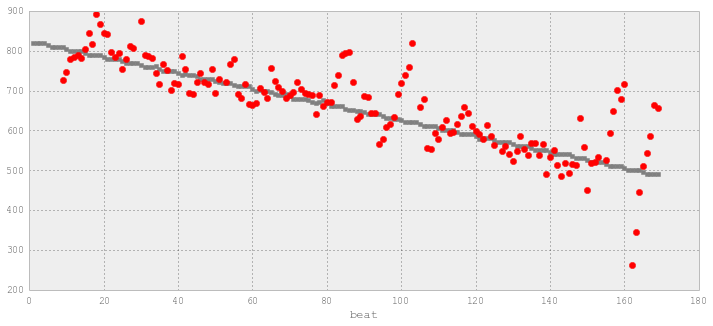

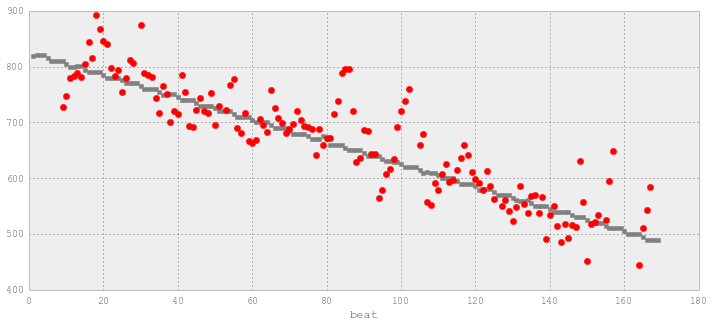

In [52]:
def relative_dev(output):
    dpercs = output.xs('tap', level='stamp').dev #_perc #.plot(figsize=(14,9))
    targetints = output.xs('target', level='stamp').tinterval #.plot()
    relative = targetints + dpercs

    mpl.pyplot.figure(figsize=(12,5))
    targetints.plot(style='.', markersize=9, color='gray')
    #mpl.pyplot.show()
    relative.plot(style='.', markersize=13, color='red')
    #relative.plot(style='--', linewidth=1, color='gray')
    
    return plt.show()

relative_dev(output)
relative_dev(output[output.is_outlier != True])

In [40]:
output

,,beat_end,beat_start,beat_target,channel,dev,dev_perc,i,interval,ints,is_outlier,micros,outlier_metric,pitch,target_spiked,task_ms,velocity
beat,stamp,,,,,,,,,,,,,,,,
0,target,409.906,0.000,0.000,NaN,0.000,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,False,0.000,NaN
1,target,1229.910,409.906,819.812,NaN,0.000,0.000000,1,819.812,NaN,NaN,1737800632,NaN,NaN,False,819.812,NaN
2,target,2050.125,1229.910,1640.008,NaN,0.000,0.000000,2,820.196,NaN,NaN,1738620828,NaN,NaN,False,1640.008,NaN
3,target,2870.355,2050.125,2460.242,NaN,0.000,0.000000,3,820.234,NaN,NaN,1739441062,NaN,NaN,False,2460.242,NaN
4,target,3688.027,2870.355,3280.468,NaN,0.000,0.000000,4,820.226,NaN,NaN,1740261288,NaN,NaN,False,3280.468,NaN
5,target,4500.576,3688.027,4095.586,NaN,0.000,0.000000,5,815.118,NaN,NaN,1741076406,NaN,NaN,False,4095.586,NaN
6,target,5310.559,4500.576,4905.566,NaN,0.000,0.000000,6,809.980,NaN,NaN,1741886386,NaN,NaN,False,4905.566,NaN
7,target,6120.554,5310.559,5715.552,NaN,0.000,0.000000,7,809.986,NaN,NaN,1742696372,NaN,NaN,False,5715.552,NaN
8,target,6930.545,6120.554,6525.556,NaN,0.000,0.000000,8,810.004,NaN,NaN,1743506376,NaN,NaN,False,6525.556,NaN
